In [4]:
import django
import pandas as pd
django.setup()

In [5]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from sch.models import *
import datetime as dt
from django.db.models import CharField
from django.test import RequestFactory
from sch.actions import *
from sch.views2 import *
from django.db.models import Sum

In [16]:
josh_op = Slot.objects.filter(employee__name='Josh',shift__name='OP')
print([op.workday.days_away for op in josh_op])

[2, 8, 9, 22, 30, 148, 155, 162, 169, 177, 183]


In [20]:
tallies = tally(list(Slot.objects.filter(shift__name="OP").values_list('employee__name',flat=True)))
df = pd.DataFrame.from_dict(sortDict(tallies,reverse=True), orient='index', columns=['count'])
df

,count
Brittanie,212
Leslie,19
Josh,11
Mandy,5
Elisia,4
David,3
None,3
Sabrina,2
Mark,2
Cheryl,2


<AxesSubplot:>

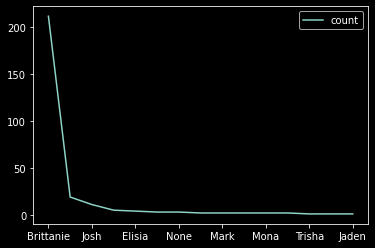

In [21]:
df.plot()

In [26]:
sch = Schedule.objects.first()

empls = Employee.objects.annotate(scheduleHours=Sum('slots__shift__hours')).order_by('-scheduleHours')
# standard schedule Hours should be 240 * the employees fte field
empls = empls.annotate(standardScheduleHours=240*F('fte'))
empls = empls.annotate(percentScheduled=F('scheduleHours')/F('standardScheduleHours')*100)
data = empls.values('name','scheduleHours','standardScheduleHours','percentScheduled')
df = pd.DataFrame.from_records(data)
df

,name,scheduleHours,standardScheduleHours,percentScheduled
0,Elisia,2202.0,240.0,917.500000
1,Brianna A,2000.0,240.0,833.333333
2,Esperanza,1950.0,240.0,812.500000
3,Danica,1930.0,240.0,804.166667
4,Mona,1916.0,240.0,798.333333
5,Brittanie,1846.0,240.0,769.166667
6,Cheryl,1806.0,240.0,752.500000
7,Jaden,1778.0,240.0,740.833333
8,Amanda,1720.0,210.0,819.047619
9,Sabrina,1696.0,120.0,1413.333333


In [34]:
def sch_solve_with_lookbehind (request, schid):
    sch = Schedule.objects.get(slug=schid)
    success_bucket = []
    emptySlots = sch.slots.empty().order_by('?')
    for slot in emptySlots:
        if slot.workday.sd_id != 0:
            prev = slot.workday.prevWD().slots.filter(shift__start__hour__lte=slot.shift.start.hour+1, shift__start__hour__gte=slot.shift.start.hour-1)
            choices = []
            for p in prev:
                if p.streak < p.employee.streak_pref and p.employee not in choices and p.employee in slot.workday.on_deck():
                    choices.append(p.employee)
            if len(choices) > 0:
                chosen = random.choice(choices)
                if PtoRequest.objects.filter(employee=chosen, workday=slot.workday.date).exists() == False:
                    if TemplatedDayOff.objects.filter(employee=chosen, sd_id=slot.workday.sd_id).exists() == False:
                        try:
                            slot.employee = chosen
                            slot.save()
                            success_bucket.append(slot)
                        except:
                            print(f"ERROR: {slot} could not be filled")
                    else: 
                        print(f"{chosen} has a templated day off on {slot.workday.date}")
                else:
                    print(f"{chosen} has a PTO request on {slot.workday.date}")
            else:
                print(f"No choices for {slot}")
                try:
                    slot.employee = random.choice(workday.on_deck())
                    slot.save()
                    success_bucket.append(slot)
                except:
                    print(f"ERROR: Backup Fill via On Deck Employees Failed. This slot was not filled. {slot}")
        else:
            print(f"{slot} is on First Sunday of Schedule")
    print(len(success_bucket) , "slots filled via method SCHEDULE_SOLVE_WITH_LOOKBEHIND")
                    
sch = Schedule.objects.filter(percent=0).first()
sch_solve_with_lookbehind(RequestFactory().get('/'),sch.slug)
sch.percent

0 slots filled via method SCHEDULE_SOLVE_WITH_LOOKBEHIND


0

In [ ]:
sch_solve_with_lookbehind(None, '2022-S8A')


['Michael', 'Leslie', 'Brittanie', 'Lindsay', 'Mona', 'Brianna-A', 'David', 'Elisia', 'Trisha', 'Sabrina', 'Jaden', 'Nick', 'Mark', 'Mandy', 'Josh', 'Tiffany', 'Esperanza', 'Cheryl', None, 'Danica', 'Amanda']
['Michael', 'Leslie', 'Brittanie', 'Lindsay', 'Mona', 'Brianna-A', 'David', 'Elisia', 'Trisha', 'Sabrina', 'Jaden', 'Nick', 'Mark', 'Mandy', 'Josh', 'Tiffany', 'Esperanza', 'Cheryl', None, 'Danica', 'Amanda']
No choices for 221204-EP None
ERROR: Backup Fill via On Deck Employees Failed. This slot was not filled. 221204-EP None
['Michael', 'Leslie', 'Brittanie', 'Lindsay', 'Mona', 'Brianna-A', 'Josh', 'David', 'Elisia', 'Trisha', 'Jaden', 'Nick', 'Mark', 'Mandy', 'Cheryl', 'Tiffany', 'Esperanza', 'Sabrina', 'Danica', None, 'Amanda']
No choices for 221217-3 None
ERROR: Backup Fill via On Deck Employees Failed. This slot was not filled. 221217-3 None
['Michael', 'Leslie', 'Brittanie', 'Lindsay', 'Mona', 'Brianna-A', 'David', 'Elisia', 'Trisha', 'Sabrina', 'Jaden', 'Nick', 'Mark', 'Ma

In [ ]:
valList = lambda list_ , val : list(list_.values_list(val,flat=True))

In [ ]:
valList(sch.slots.filled(), 'employee')
sch.save()
sch.percent

95